## Generating convolutional Transfer learning neuronal networks based models
Christian SOLIS CALERO

In [ ]:
# Cargar el Drive helper y mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/PA_DL_models

/content/drive/MyDrive/Capacitaciones/Diplomado-Machine_learning-SARS-Cov2/Proyecto_deep_learning/Covid_Data_GradientCrescent/PA_DL_models


In [ ]:
import tensorflow as tf
from numpy.random import seed
seed(8) #1
tf.random.set_seed(7) 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
from os import listdir
data_list = listdir('../twoF/train')

Case 1: COVID vs Normal
VGG Initialization

## Declaración de variables e importacion de librerias

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf

In [ ]:
DATASET_PATH  = '../twoF/train'
test_dir =  '../twoF/test'
IMAGE_SIZE    = (150, 150)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE =0.0005 #start off with high rate first 0.001 #5e-4

#Train datagen here is a preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                    fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="binary",
                                                 
                                                  )

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="binary",
                                                 
                                                  )

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 608 images belonging to 2 classes.
Found 151 images belonging to 2 classes.


Layer Modification at upper layer of VGG16

In [ ]:
#Simple CNN model based on VGG16
from tensorflow.keras import models
from tensorflow.keras import layers
#from keras.applications import VGG16
#from keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
from keras.layers.core import Flatten, Dense, Dropout, Lambda

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.trainable = False
model = None
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              #optimizer=optimizers.Adam(lr=LEARNING_RATE),
              optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),              
              metrics=['acc'])

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
None


## Training and Validation of the model

In [ ]:
import os
ruta_directorio='/content/drive/MyDrive/Capacitaciones/Diplomado-Machine_learning-SARS-Cov2/Proyecto_deep_learning/Covid_Data_GradientCrescent/PA_DL_models'
weight_saver = ModelCheckpoint(os.path.join(ruta_directorio, 'Covid_PA_vgg16_weights.h5'), monitor='val_acc', mode='max', save_best_only=True, save_weights_only=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_acc', 
    patience=20, 
    min_delta=0.0001, 
    mode='max')

In [ ]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))
STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size
result=model.fit_generator(train_batches,
                        steps_per_epoch =STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= NUM_EPOCHS,
                        callbacks = [weight_saver,early_stopping],
#                       
                       )

61
16


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
60/60 [==============================] - 463s 7s/step - loss: 0.3235 - acc: 0.8629 - val_loss: 0.1149 - val_acc: 0.9467
Epoch 2/100
60/60 [==============================] - 21s 348ms/step - loss: 0.1335 - acc: 0.9482 - val_loss: 0.1681 - val_acc: 0.9467
Epoch 3/100
60/60 [==============================] - 19s 320ms/step - loss: 0.1280 - acc: 0.9498 - val_loss: 0.1042 - val_acc: 0.9667
Epoch 4/100
60/60 [==============================] - 20s 328ms/step - loss: 0.1058 - acc: 0.9599 - val_loss: 0.1031 - val_acc: 0.9600
Epoch 5/100
60/60 [==============================] - 19s 322ms/step - loss: 0.0815 - acc: 0.9799 - val_loss: 0.1985 - val_acc: 0.9267
Epoch 6/100
60/60 [==============================] - 20s 338ms/step - loss: 0.0923 - acc: 0.9649 - val_loss: 0.1581 - val_acc: 0.9200
Epoch 7/100
60/60 [==============================] - 20s 335ms/step - loss: 0.1136 - acc: 0.9615 - val_loss: 0.0946 - val_acc: 0.9667
Epoch 8/100
60/60 [==============================] - 19s 321ms/s

In [ ]:
model.save('Covid_PA_vgg16_Epochs.h5')

In [ ]:
# Guardar configuración JSON en el disco
json_config = model.to_json()
with open('Covid_PA_vgg16_config.json', 'w') as json_file:
    json_file.write(json_config)

Evaluation

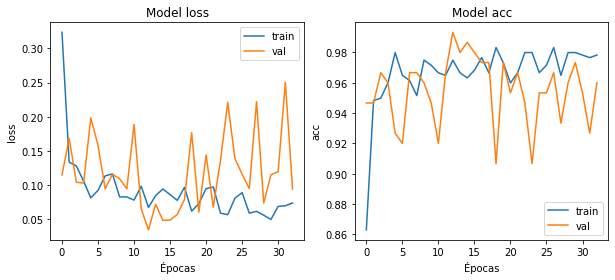

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.ravel()

for i, met in enumerate(["loss", "acc"]):
    ax[i].plot(result.history[met])
    ax[i].plot(result.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("Épocas")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [ ]:
import matplotlib.pyplot as plt

def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Val_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Val_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    return acc #adicionado solo para que no salga los warnings

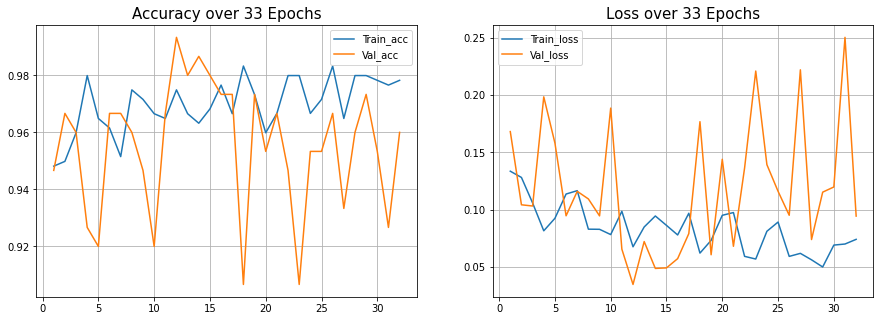

In [ ]:
acc=plot_acc_loss(result, 33)

## Upload Model

In [ ]:
!ls

all
COVID19_Detection_Transfer_Learning_VGG16
COVID19_Detection_Transfer_Learning_VGG16-master.zip
Covid_Binary.h5
Covid_Binary_vgg16-02.h5
Covid_Binary_vgg16.h5
Covid_Data_GradientCrescent.zip
Evaluating_models.ipynb
two


In [ ]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('Covid_Binary_vgg16.h5')
# summarize model.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


## Testing the model

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255) # Escalamiento de imagenes cada valor de la matriz va a dividirlo entre 255

#Generando la relación estructura del modelo data test
eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=1, #No de muestras que actualiza la gradiente
        shuffle=False,
        seed=42,
        class_mode="binary")
eval_generator.reset()    

Found 330 images belonging to 2 classes.


In [ ]:
#Prevalua el modelo para calcular el accuracy y el loss un número de veces: #imagenes/batch size
eval_generator.reset()  
#x = model.evaluate_generator(eval_generator,
x = model.evaluate(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE), #Número de grupos
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1
                           )
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

33/33 [==============================] - 12s 368ms/step - loss: 0.4532 - acc: 0.7879
Test loss: 0.4532356262207031
Test accuracy: 0.7878788113594055


Predict

In [ ]:
eval_generator.reset()  
pred = model.predict_generator(eval_generator,330,verbose=1)
#pred = model.predict(eval_generator,1000,verbose=1)
print("Predictions finished")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


330/330 [==============================] - 186s 563ms/step
Predictions finished


covid/nejmoa2001191_f3-PA.jpeg


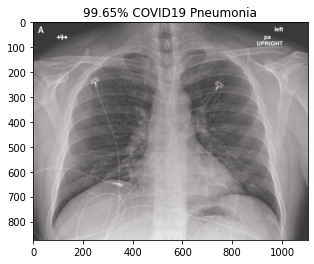

covid/nejmoa2001191_f4.jpeg


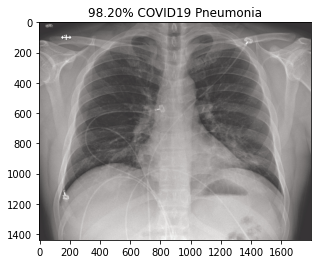

covid/nejmoa2001191_f5-PA.jpeg


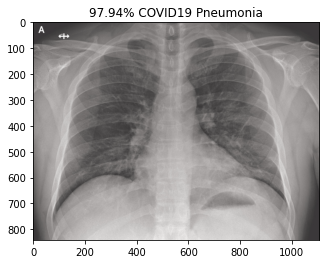

covid/radiol.2020200490.fig3.jpeg


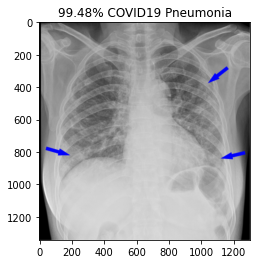

covid/ryct.2020200028.fig1a.jpeg


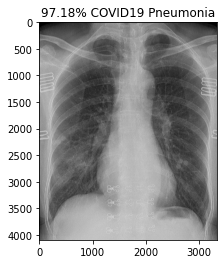

covid/ryct.2020200034.fig2.jpeg


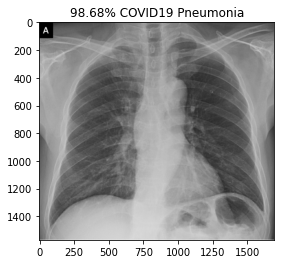

covid/ryct.2020200034.fig5-day0.jpeg


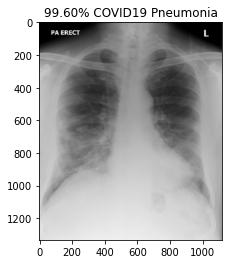

covid/ryct.2020200034.fig5-day4.jpeg


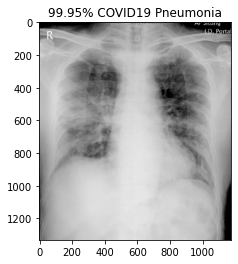

covid/ryct.2020200034.fig5-day7.jpeg


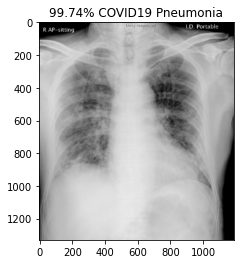

normal/NORMAL2-IM-1385-0001.jpeg


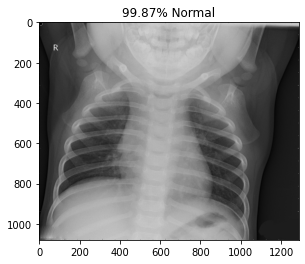

normal/NORMAL2-IM-1396-0001.jpeg


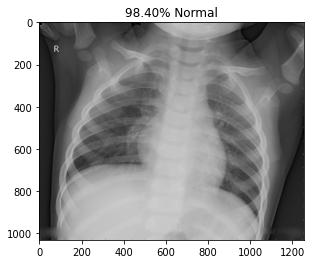

normal/NORMAL2-IM-1400-0001.jpeg


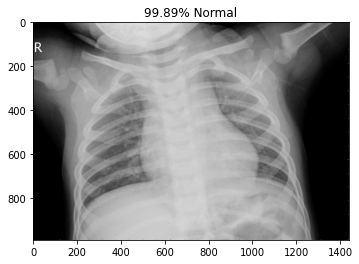

normal/NORMAL2-IM-1401-0001.jpeg


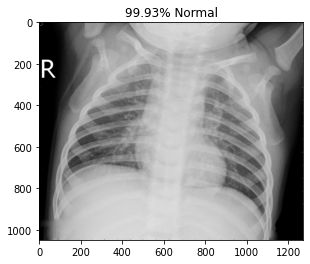

normal/NORMAL2-IM-1406-0001.jpeg


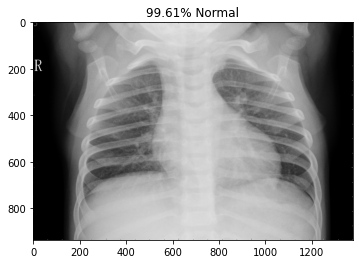

normal/NORMAL2-IM-1412-0001.jpeg


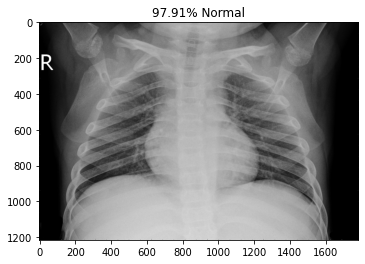

normal/NORMAL2-IM-1419-0001.jpeg


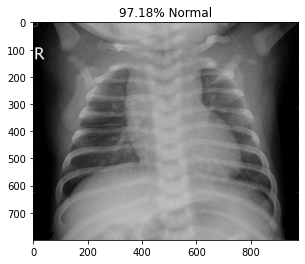

normal/NORMAL2-IM-1422-0001.jpeg


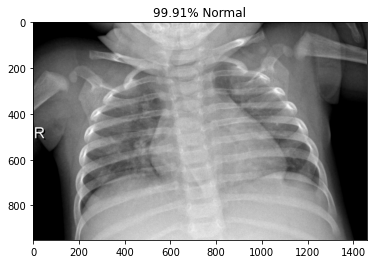

normal/NORMAL2-IM-1423-0001.jpeg


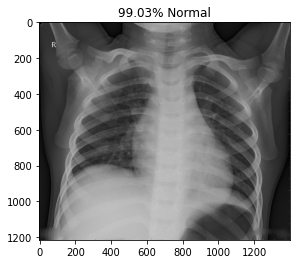

In [ ]:
#
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
for index, probability in enumerate(pred):
    image_path = test_dir + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    #BGR TO RGB conversion using CV2
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

In [ ]:
import re
labels=[]
resultados=[]
probabilidades=[]
prob_normal=[]
prob_covid=[]

In [ ]:
regex = re.compile('\/')

In [ ]:
#Obtaining only prediction of classes
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
for index, probability in enumerate(pred):
    labels.append(regex.split(eval_generator.filenames[index])[0])

    prob_normal.append(probability[0])
    prob_covid.append((1-probability[0]))

    if probability > 0.5:
        resultados.append("normal")
        probabilidades.append(probability[0])
    else:
        resultados.append("covid")
        probabilidades.append(1-probability[0])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
regex2 = re.compile('\_')

In [ ]:
#print(regex2.split(model)[2])
print('Confusion Matrix')
print(confusion_matrix(labels, resultados))
print('')
print('Classification Report')
target_names = ['covid', 'normal']
print(classification_report(labels, resultados, target_names=target_names))

Confusion Matrix
[[ 71  15]
 [  0 244]]

Classification Report
              precision    recall  f1-score   support

       covid       1.00      0.83      0.90        86
      normal       0.94      1.00      0.97       244

    accuracy                           0.95       330
   macro avg       0.97      0.91      0.94       330
weighted avg       0.96      0.95      0.95       330



ROC curve and auc on an imbalanced dataset

In [ ]:
valores=[1 if labels[i]=="covid" else 0 for i in range(len(labels))]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(valores))]
# calculate scores
ns_auc = roc_auc_score(valores, ns_probs)
covid_auc = roc_auc_score(valores, prob_covid)

No Skill: ROC AUC=0.500
vgg16: ROC AUC=0.999


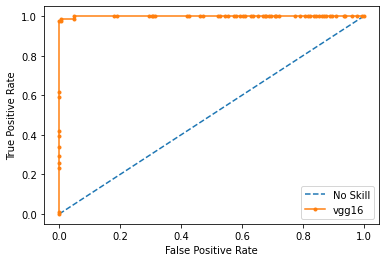

In [ ]:
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('vgg16: ROC AUC=%.3f' % (covid_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(valores, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(valores, prob_covid)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='vgg16')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Deep learning: f1=0.904 auc=0.998


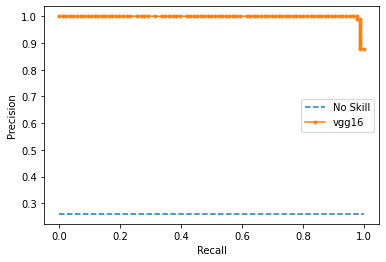

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
val_result=[1 if resultados[i]=="covid" else 0 for i in range(len(resultados))]
val_result=np.array(val_result)
valoresA=np.array(valores)

# predict class values
yhat = val_result
lr_precision, lr_recall, _ = precision_recall_curve(valoresA, prob_covid)
lr_f1, lr_auc = f1_score(valoresA, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Deep learning: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(valoresA[valoresA==1]) / len(valoresA)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='vgg16')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()